In [28]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import yaml
import janitor as pj
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import Phrases, LdaModel
from gensim.test.utils import datapath
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle

In [29]:
!dvc pull

Everything is up to date.


### Descriptive Statistics

In [30]:
# Pull in data

df = pd.read_feather('data/descriptive')

In [31]:
# Quick check top words

pd.DataFrame(df.speech.value_counts().head(20))

,speech
international,5407
problem,5119
humanitarian,4741
people,4610
government,4442
protection,4346
need,4234
office,4207
solution,3691
new,3493


In [32]:
### Generate top word counts by commissioner

freq = pd.DataFrame(df.groupby('speaker')['speech']
                        .value_counts()
                        .groupby(level=0, group_keys=False).head(10)
                       )
freq.columns = ['freq']
freq = freq.reset_index()
freq.columns = ['speaker', 'word', 'freq']

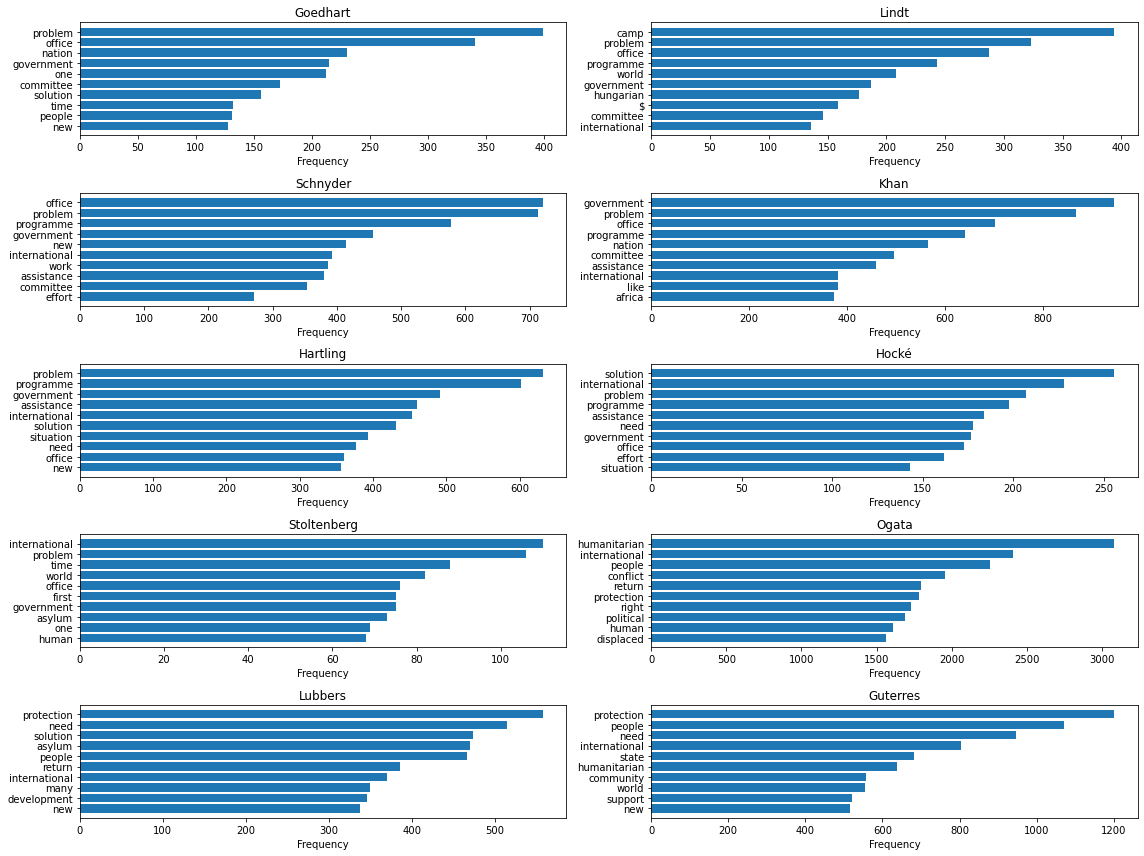

In [33]:
### Plot word frequencies by commissioner

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(16, 12))

speaker = ['Goedhart', 
           'Lindt', 
           'Schnyder', 
           'Khan', 
           'Hartling', 
           'Hocké', 
           'Stoltenberg', 
           'Ogata', 
           'Lubbers', 
           'Guterres']
j = 1

for n in speaker:
    a = eval('ax' + str(j))
    
    y_pos = freq[freq.speaker == n].word
    
    count = freq[freq.speaker == n].freq
    
    a.barh(y_pos, count)
    
    a.set_yticks(y_pos, labels=freq[freq.speaker == n].word)
    a.invert_yaxis()
    a.set_xlabel('Frequency')
    a.set_title(n)
    
    j = j + 1

plt.tight_layout()

In [34]:
freq = pd.DataFrame(df.groupby('decade')['speech']
                        .value_counts()
                        .groupby(level=0, group_keys=False).head(10)
                       )
freq.columns = ['freq']
freq = freq.reset_index()
freq.columns = ['decade', 'word', 'freq']

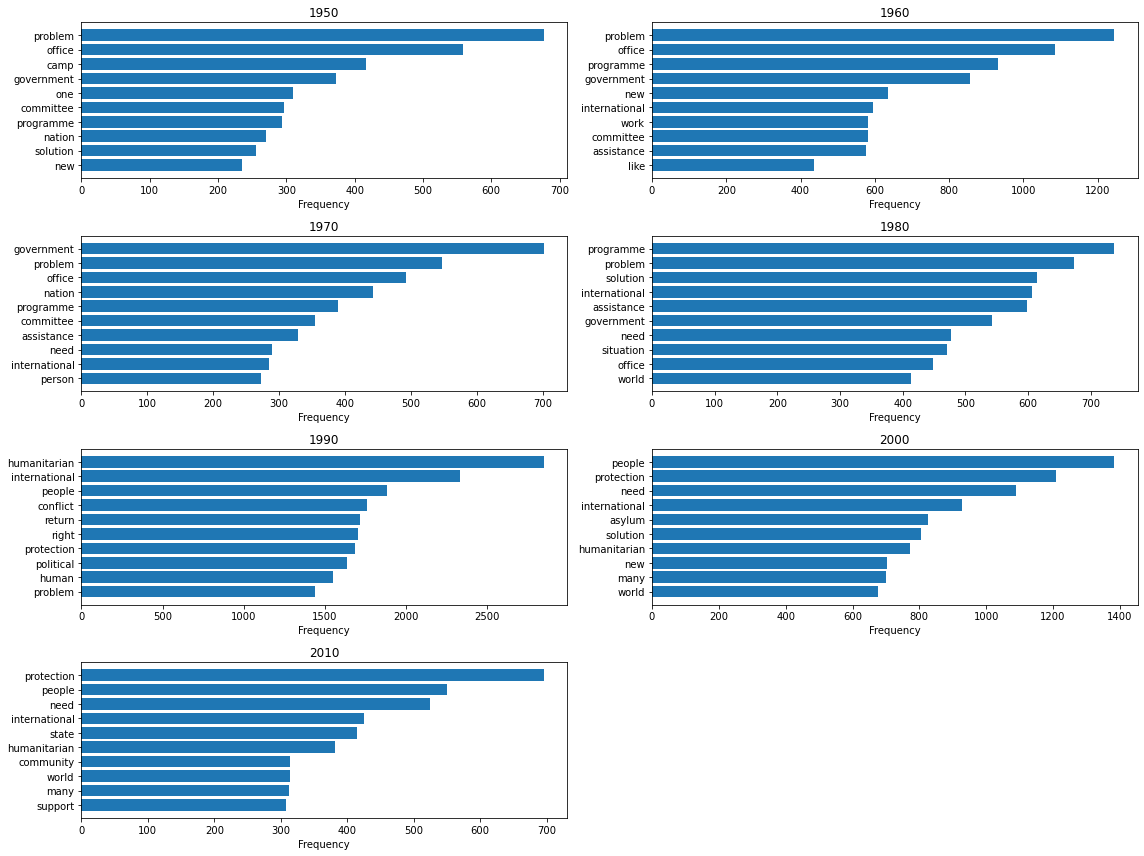

In [35]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(16, 12))

j = 1
decade = [1950, 1960, 1970, 1980, 1990, 2000, 2010]

for n in decade:
    a = eval('ax' + str(j))
    
    y_pos = freq[freq.decade == n].word
    
    count = freq[freq.decade == n].freq
    
    a.barh(y_pos, count)
    
    a.set_yticks(y_pos, labels=freq[freq.decade == n].word)
    a.invert_yaxis()
    a.set_xlabel('Frequency')
    a.set_title(n)
    
    j = j + 1

fig.delaxes(ax8)
plt.tight_layout()

### Topic Model

In [36]:
# Pull in model

topic_model = gensim.models.ldamodel.LdaModel.load('lda_model')
dictionary = corpora.Dictionary.load('speech.dict')
corpus = corpora.MmCorpus('speech.mm')
with open('data/docs', 'rb') as fp:
    docs = pickle.load(fp)
with open('data/docs_tagged', 'rb') as fp:
    docs_tagged = pickle.load(fp)

In [37]:
vis_data = gensimvis.prepare(topic_model, corpus, dictionary)

C:\Users\jeffw\miniforge3\envs\unhcr_speeches\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [38]:
pyLDAvis.display(vis_data)

In [52]:
topic_model.show_topics()

[(0,
  '0.010*"asia" + 0.009*"cpa" + 0.008*"region" + 0.007*"asylum" + 0.006*"vietnam" + 0.006*"million" + 0.006*"political" + 0.005*"vietnamese" + 0.005*"resettlement" + 0.005*"comprehensive"'),
 (1,
  '0.008*"syrian" + 0.008*"syria" + 0.007*"child" + 0.007*"crisis" + 0.007*"conflict" + 0.006*"million" + 0.005*"region" + 0.005*"border" + 0.005*"host" + 0.004*"international_community"'),
 (2,
  '0.010*"programme" + 0.006*"committee" + 0.006*"africa" + 0.005*"nation" + 0.004*"development" + 0.004*"general" + 0.004*"million" + 0.004*"may" + 0.003*"voluntary" + 0.003*"person"'),
 (3,
  '0.006*"development" + 0.004*"process" + 0.004*"staff" + 0.004*"displaced" + 0.004*"unhcrs" + 0.004*"million" + 0.004*"challenge" + 0.003*"displacement" + 0.003*"asylum" + 0.003*"approach"'),
 (4,
  '0.025*"asylum" + 0.013*"europe" + 0.011*"right" + 0.010*"european" + 0.008*"convention" + 0.008*"nansen" + 0.007*"nation" + 0.005*"seeker" + 0.005*"asylum_seeker" + 0.005*"system"'),
 (5,
  '0.025*"return" + 0.

In [40]:
# Pull in topics over time 

topics_over_time = pd.read_feather('data/topics_over_time')

In [66]:
topics_over_time.columns = [['year', 
                            'Comprehensive Plan of Action for Indochinese Refugees', 
                            'Syria crisis',
                            'Decolonization in Africa',
                            'Refugees and development',
                            'International laws and conventions',
                            'Returns in the Balkans',
                            'Bearing witness and human rights abuses',
                            'Refugee assistance model',
                            'Conflict in the Balkans',
                            'Conflict and security']]

In [68]:
x = topics_over_time['year'].astype(int) + 1970
y1 = topics_over_time['Comprehensive Plan of Action for Indochinese Refugees']
y2 = topics_over_time['Syria crisis']
y3 = topics_over_time['Decolonization in Africa']
y4 = topics_over_time['Refugees and development']
y5 = topics_over_time['International laws and conventions']
y6 = topics_over_time['Returns in the Balkans']
y7 = topics_over_time['Bearing witness and human rights abuses']
y8 = topics_over_time['Refugee assistance model']
y9 = topics_over_time['Conflict in the Balkans']
y10 = topics_over_time[ 'Conflict and security']

In [82]:
list(topics_over_time.columns.values[1])

['Comprehensive Plan of Action for Indochinese Refugees']

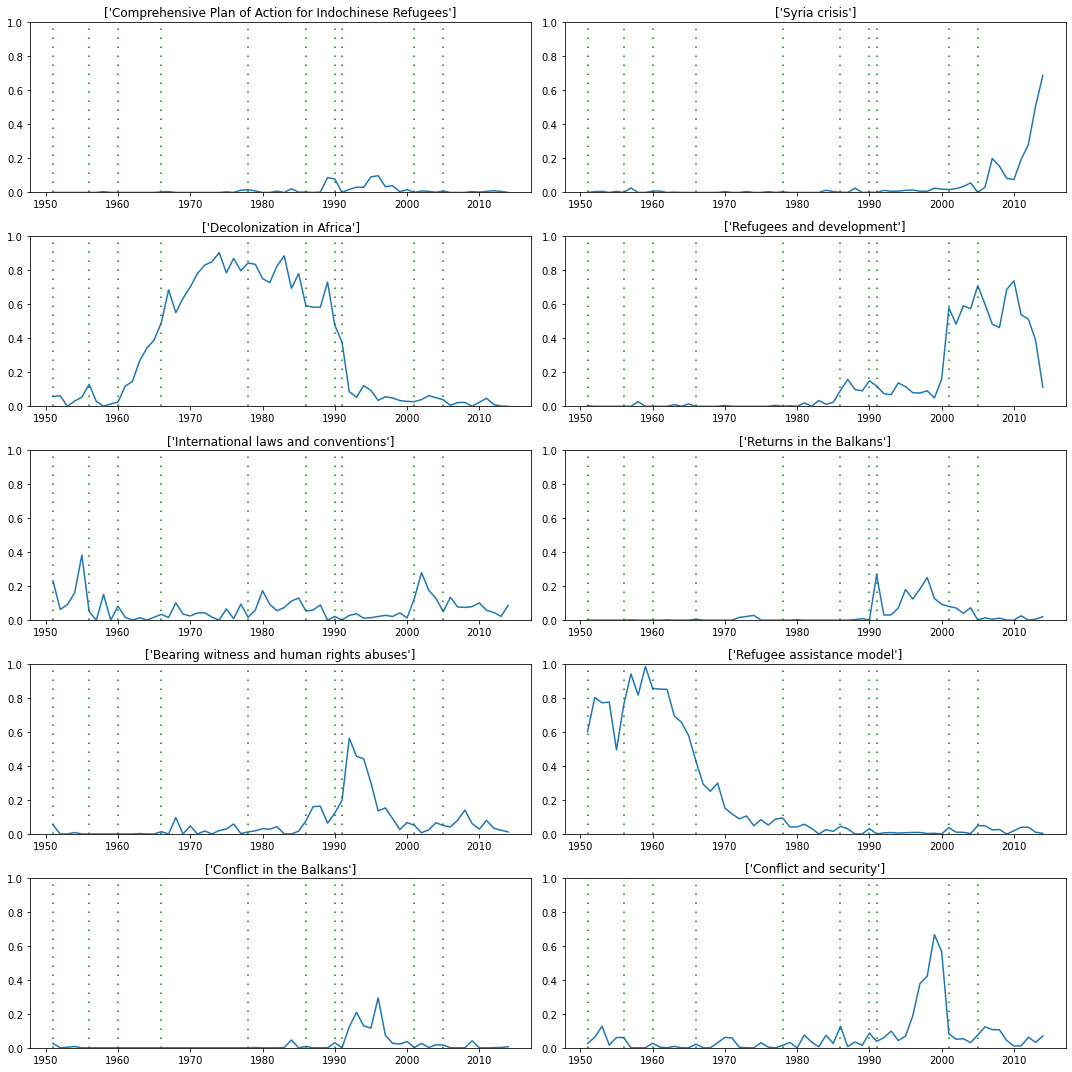

In [87]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 15))

for j in range(1, 11):
    a = eval('ax' + str(j))
    y = eval('y' + str(j)) 
    title = list(topics_over_time.columns.values[j]))
    a.plot(x, y)
    a.set_title(title)
    a.set(ylim=(0, 1))
    a.axvline(x= 1951, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1956, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1960, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1966, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1978, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1986, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1990, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1991, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 2001, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 2005, color='green', linestyle=(0, (1, 5)))

plt.tight_layout()

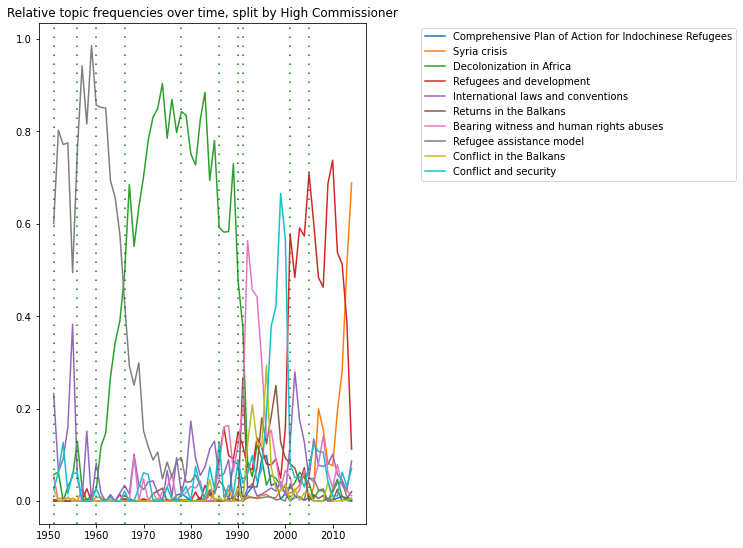

In [54]:
plt.figure(figsize=(10, 7.5), layout = 'constrained')
plt.plot(x, y1, label = 'Comprehensive Plan of Action for Indochinese Refugees')
plt.plot(x, y2, label = 'Syria crisis')
plt.plot(x, y3, label = 'Decolonization in Africa')
plt.plot(x, y4, label = 'Refugees and development')
plt.plot(x, y5, label = 'International laws and conventions')
plt.plot(x, y6, label = 'Returns in the Balkans')
plt.plot(x, y7, label = 'Bearing witness and human rights abuses')
plt.plot(x, y8, label = 'Refugee assistance model')
plt.plot(x, y9, label = 'Conflict in the Balkans')
plt.plot(x, y10, label = 'Conflict and security')
plt.axvline(x= 1951, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1956, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1960, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1966, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1978, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1986, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1990, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1991, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 2001, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 2005, color='green', linestyle=(0, (1, 5)))
plt.legend(bbox_to_anchor=(1.15,1))
plt.title("Relative topic frequencies over time, split by High Commissioner")
plt.show()